In [60]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
device

device(type='cuda')

In [62]:
IMAGE_PATH = '../dataset_segmentation/images/'
MASK_PATH = '../dataset_segmentation/masks/'

In [63]:
n_classes = 1

In [64]:
# Create a dataframe of image IDs based on filenames
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            if filename.startswith("image_"):
                name.append(filename.split('.')[0])
    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  10000


In [65]:
df.head(10)

,id
0,image_0
1,image_1
2,image_10
3,image_100
4,image_1000
5,image_1001
6,image_1002
7,image_1003
8,image_1004
9,image_1005


In [66]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  7650
Val Size     :  1350
Test Size    :  1000


Image Size: (480, 640, 3)
Mask Size: (480, 640)


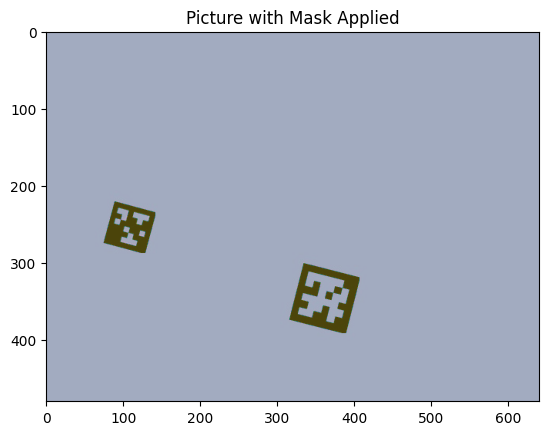

In [122]:
image_id = df['id'][236]
img = Image.open(f"{IMAGE_PATH}{image_id}.jpg")
mask_id = image_id.replace("image", "mask")  # Adjust the id to match mask filenames
mask = Image.open(f"{MASK_PATH}{mask_id}.png")

# Print the image and mask sizes
print('Image Size:', np.asarray(img).shape)
print('Mask Size:', np.asarray(mask).shape)

# Display image with mask overlay
plt.imshow(img)
plt.imshow(mask, alpha=0.3)
plt.title('Picture with Mask Applied')
plt.show()

In [108]:
class AprilTagDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        img = np.array(img, dtype=np.uint8)
        mask = np.array(mask, dtype=np.uint8)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [109]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()], is_check_shapes=False)

t_val = A.Compose([A.GridDistortion(p=0.2)], is_check_shapes=False)

#datasets
train_set = AprilTagDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = AprilTagDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [110]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=1, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [111]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [112]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [113]:
def mIoU(pred_mask, mask, smooth=1e-10):
    with torch.no_grad():
        pred_mask = F.sigmoid(pred_mask)  # Use sigmoid for binary segmentation
        pred_mask = (pred_mask > 0.5).float()  # Threshold to get binary prediction
        pred_mask = pred_mask.view(-1)
        mask = mask.view(-1)

        intersect = torch.logical_and(pred_mask == 1, mask == 1).sum().float().item()
        union = torch.logical_or(pred_mask == 1, mask == 1).sum().float().item()
        
        iou = (intersect + smooth) / (union + smooth)
        return iou

In [114]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [115]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        # Training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            
            # Forward pass
            output = model(image)
            loss = criterion(output, mask)
            
            # Calculate metrics
            iou_score += mIoU(output, mask)  # Adjusted mIoU for single class
            accuracy += pixel_accuracy(output, mask)  # Adjusted pixel accuracy for binary task
            
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
        
        # Step the scheduler per epoch (if StepLR or similar)
        lrs.append(get_lr(optimizer))
        scheduler.step()

        # Validation loop
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                image_tiles, mask_tiles = data
                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)
                
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                output = model(image)
                
                # Calculate validation metrics
                val_iou_score += mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                
                # Calculate loss
                loss = criterion(output, mask)
                test_loss += loss.item()
        
        # Calculate mean losses and metrics per batch
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(val_loader))

        # Save model if validation loss decreases
        if min_loss > (test_loss / len(val_loader)):
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
            min_loss = (test_loss / len(val_loader))
            decrease += 1
            if decrease % 5 == 0:
                print('Saving model...')
                torch.save(model.state_dict(), f'Unet-Mobilenet_v2_mIoU-{val_iou_score / len(val_loader):.3f}.pt')
        
        # Early stopping if loss does not improve
        if (test_loss / len(val_loader)) > min_loss:
            not_improve += 1
            min_loss = (test_loss / len(val_loader))
            print(f'Loss Not Decreasing for {not_improve} time(s)')
            if not_improve == 7:
                print('Loss not decreasing for 7 times, stopping training')
                break
        
        # Record metrics per epoch
        val_iou.append(val_iou_score / len(val_loader))
        train_iou.append(iou_score / len(train_loader))
        train_acc.append(accuracy / len(train_loader))
        val_acc.append(test_accuracy / len(val_loader))
        
        print(f"Epoch {e + 1}/{epochs}.. "
              f"Train Loss: {running_loss / len(train_loader):.3f}.. "
              f"Val Loss: {test_loss / len(val_loader):.3f}.. "
              f"Train mIoU: {iou_score / len(train_loader):.3f}.. "
              f"Val mIoU: {val_iou_score / len(val_loader):.3f}.. "
              f"Train Acc: {accuracy / len(train_loader):.3f}.. "
              f"Val Acc: {test_accuracy / len(val_loader):.3f}.. "
              f"Time: {(time.time() - since) / 60:.2f}m")
    
    # Summary of training history
    history = {
        'train_loss': train_losses, 'val_loss': test_losses,
        'train_miou': train_iou, 'val_miou': val_iou,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lrs': lrs
    }
    
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    return history

In [116]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

# Use BCEWithLogitsLoss for binary segmentation
criterion = nn.BCEWithLogitsLoss()

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

# Run training
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/2550 [00:00<?, ?it/s]


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'